In [79]:
import batteryCell as cell
import numpy as np
from cellESR import LookupTableEstimator as lte
from cellESR import cellESR as ce
import matplotlib.pyplot as plt

In [80]:
# Debug: Check which batteryCell module is being imported
import importlib
import batteryCell as cell

# Force reload the module to get latest changes
importlib.reload(cell)




<module 'batteryCell' from 'c:\\repos\\MOSart_cellModelling\\pythonModel\\batteryCell.py'>

In [81]:
Nx=1 # Number of states
Nxa=3 # Augmented number of states
Ny=1 # Number of measurements
h=np.sqrt(3) # scaling parameter
inv_2h2 = 1 / (2 * h**2) # 1/(2*h^2)
Wmx=np.array([0]) # Wmx0 = (h**2-Nxa) / (h**2) which is essentially 0 for Nxa=3, h=sqrt(3)
Wmx=np.append(Wmx,[inv_2h2]*(2*Nxa)) # Wmxi = 1/(2*h^2) for i=1,...,2*Nxa
rtWmx=np.sqrt(Wmx)

In [82]:

R0=0.015 # Internal resistance [Ohm]
RZlist=[[1e-3,10,0],[1.5e-3,1e4,0]]
dt=1
time=0
ocv_table="Sample_OCV_DoD.csv"
cesr=ce(R0,RZlist)
ocv_lookup=lte(ocv_table)
corner="mc"
# Recreate battery cell with reloaded module
battery=cell.Cell(chemID="Li-ion", R0=R0, RZlist=RZlist,corner=corner,seed=42)
# battery.SoC=[50]
# battery.SoH=[100]

print(f"Initial SoH: {battery.SoH[-1]}")
print("Battery object recreated with updated module")
SigmaW=0.0001*(1/1950)  # Process noise covariance
SigmaV= 0.000001 # Measurement noise covariance
xtrue=battery.SoC[-1] # True state
xhat=battery.SoC[-1] # Estimated state
SigmaX=1 # Initial state covariance

print(f"Battery corner: {corner}")
print(f"Actual MaxCapacity: {battery.MaxCapacity:.0f} mAh")
print(f"Actual Coulomb Efficiency: {battery.coulombEffeciency[-1]:.3f}")
print(f"Actual SoH: {battery.SoH[-1]:.1f}%")
print(f"Actual SoC: {battery.SoC[-1]:.1f}%")

# Data logging
time_log=[time]
seqs=15
import pandas as pd
import numpy as np
test_sequence = "test_sequence.csv"
test=pd.read_csv(test_sequence)
dtt=test['Time'][1]-test['Time'][0]
maxIter= int(seqs*dtt)
xstore=np.zeros(maxIter+1)
xstore[0]=xtrue
xhatstore=np.zeros(maxIter+1)
xhatstore[0]=xhat
SigmaXstore=np.zeros(maxIter+1)
SigmaXstore[0]=SigmaX
SoH_log=[battery.SoH[-1]]
voltage_log=[battery.ocv[-1]+battery.current[-1]*battery.esr[-1]]
current_log=[battery.current[-1]]
dSoC_log=np.zeros(maxIter)
OCV_store=np.zeros(maxIter+1)
OCV_store[0]=battery.ocv[-1]

Initial SoH: 95.6476885381007
Battery object recreated with updated module
Battery corner: mc
Actual MaxCapacity: 65149 mAh
Actual Coulomb Efficiency: 0.888
Actual SoH: 95.6%
Actual SoC: 96.5%


In [83]:
import pandas as pd
import numpy as np
test_sequence = "test_sequence.csv"
test=pd.read_csv(test_sequence)
for ii in range(seqs):
    print(battery.SoC[-1])
    current=test['Current'][ii]
    curr=current
    temp=test['Temperature'][ii]
    indadd=ii*int(dtt)
    for k in range(int(dtt)):
        if(xhat<=1.1):
            print("SoC estimate below 1.1%, stopping simulation.")
            break
        xhata=np.array([xhat,0,0]).reshape(-1,1) # Augmented state
        SigmaXa=np.diag([SigmaX,SigmaW,SigmaV]) # Augmented state covariance
        sSigmaxa=np.linalg.cholesky(SigmaXa) # Cholesky factorization
        X=np.zeros((Nxa,2*Nxa+1)) # Sigma points matrix
        X[:,0]=xhata[:,0] # First sigma point
        for i in range(Nxa):
            X[:,i+1]=xhata[:,0]+h*sSigmaxa[:,i]
            X[:,i+1+Nxa]=xhata[:,0]-h*sSigmaxa[:,i]
        discharge=curr*dt # Discharge in As
        dSoC=100*discharge/(3.6*battery.coulombEffeciency[-1]*battery.MaxCapacity*battery.SoH[-1]/100) # Change in SoC considering SoH
        dSoC_log[k+indadd]=dSoC
        Xx=X[0,:]-dSoC # Extract state sigma points
        # print(Xx)
        result=np.sum(Wmx*Xx) # Predicted state mean
        xhat=result
        Xs=(Xx-xhat)*rtWmx # Predicted state covariance
        SigmaX=np.sum(Xs**2)
        # print(SigmaX)
        w=np.random.normal(0,np.sqrt(SigmaW)) # Process noise
        v=np.random.normal(0,np.sqrt(SigmaV)) # Measurement noise
        battery(time,curr+w,temp) # Simulate cell for one time step
        xtrue=battery.SoC[-1] # True state

        ytrue=battery.voltage[-1]+v # Measurement
        OCV=ocv_lookup.estimateOCV(100-Xx,temp) # Measurement prediction

        # print(OCV)
        Y=OCV*battery.ocvSoH_gain()+curr*cesr.calculateESR(curr,dt)+X[2,:] # Measurement sigma points
        # print(Y )
        # print(i*cesr.calculateESR(i,dt))
        yhat=np.sum(Wmx*Y) # Predicted measurement mean
        OCV_store[k+indadd]=yhat*battery.ocvSoH_gain()-curr*cesr.calculateESR(curr,dt)
        voltage_log.append(yhat)
        Ys=(Y-yhat)*rtWmx # Predicted measurement covariance
        SigmaY=np.sum(Ys**2)
        SigmaXY=np.sum(Xs*Ys) # Cross covariance
        K=SigmaXY/SigmaY # Kalman gain
        xhat=xhat+K*(ytrue-yhat) # State update
        # if(abs(xhat-xtrue)>5 and k>20):
        #     print(xhat,xtrue,k)
        #     break
        SigmaX=SigmaX-K*SigmaY*K # State covariance update
        time+=dt
        time_log.append(time)
        xstore[k+indadd+1]=xtrue
        xhatstore[k+indadd+1]=xhat
        SigmaXstore[k+indadd+1]=SigmaX
        SoH_log.append(battery.SoH[-1])
        # voltage_log.append(battery.voltage[-1])
        current_log.append(curr)

        # if(battery.SoH[-1]<100):
        #    print(battery.SoH[-1],k)
        #    break

# print(xstore)


96.52302985640803
SoCdegradation called
90.66136711688587
82.83276635371143
73.04702103921443
61.30413268962102
47.60409344209257
32.92548058638415
19.225434760649875
6.5039665277653675
SoC estimate below 1.1%, stopping simulation.
1.1022366533200898
SoC estimate below 1.1%, stopping simulation.
1.1022366533200898
SoC estimate below 1.1%, stopping simulation.
1.1022366533200898
SoC estimate below 1.1%, stopping simulation.
1.1022366533200898
SoC estimate below 1.1%, stopping simulation.
1.1022366533200898
SoC estimate below 1.1%, stopping simulation.
1.1022366533200898
SoC estimate below 1.1%, stopping simulation.


5077 5077

UKF Performance Metrics:
Mean SoC estimation error: 0.041%
Maximum SoC estimation error: 1.741%
Final SoC error: 0.013%


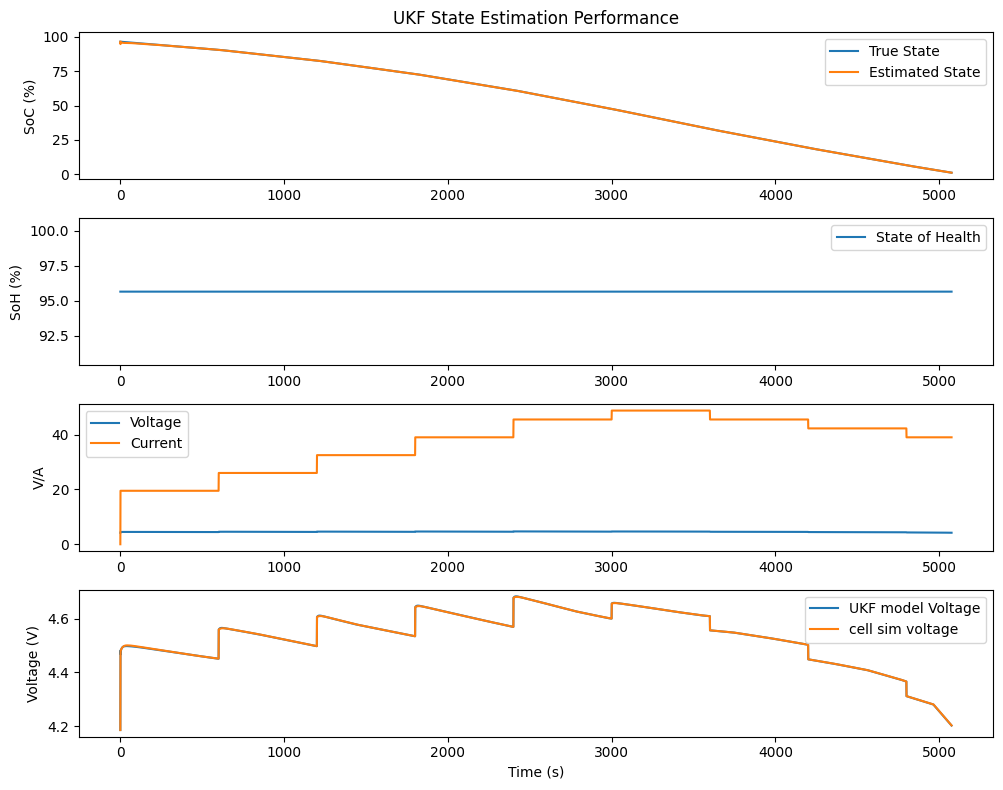

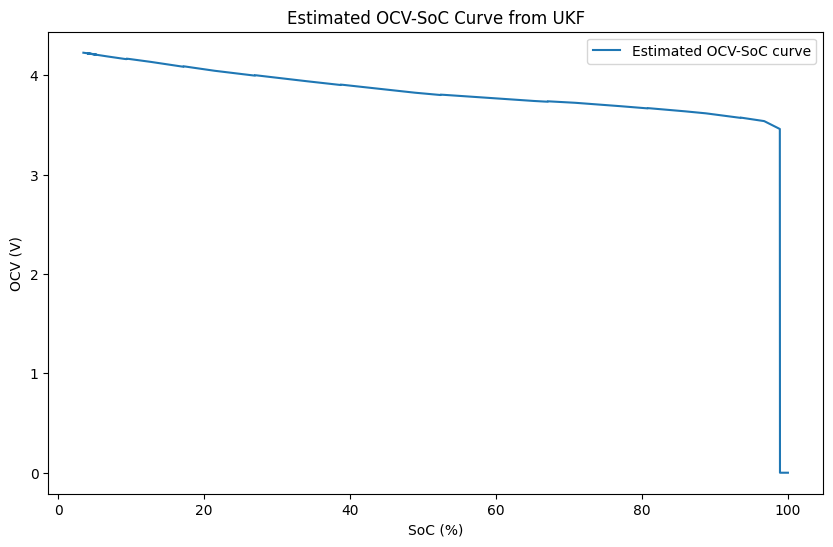

In [84]:

plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
print(len(xstore[0:len(time_log)]),len(time_log))
plt.plot(time_log,xstore[0:len(time_log)],label='True State')
plt.plot(time_log,xhatstore[0:len(time_log)],label='Estimated State')
plt.fill_between(time_log,xhatstore[0:len(time_log)]-1.96*np.sqrt(SigmaXstore[0:len(time_log)]),xhatstore[0:len(time_log)]+1.96*np.sqrt(SigmaXstore[0:len(time_log)]),alpha=0.2)
plt.legend()
plt.ylabel('SoC (%)')
plt.title('UKF State Estimation Performance')
plt.subplot(4,1,2)
plt.plot(time_log,SoH_log,label='State of Health')
plt.legend()
plt.ylabel('SoH (%)')
plt.subplot(4,1,3)
plt.plot(time_log,voltage_log,label='Voltage')
plt.plot(time_log,current_log,label='Current')
plt.legend()
plt.ylabel('V/A')
plt.subplot(4,1,4)
plt.plot(time_log,voltage_log[0:len(time_log)],label='UKF model Voltage')
# Fix length mismatch by using the minimum length
min_len = min(len(time_log), len(battery.voltage))
plt.plot(time_log[0:min_len],battery.voltage[0:min_len],label='cell sim voltage')
plt.legend()
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')

# Calculate and display accuracy metrics
soc_error = np.abs(np.array(xstore[0:len(time_log)]) - np.array(xhatstore[0:len(time_log)]))
mean_error = np.mean(soc_error)
max_error = np.max(soc_error)
print(f"\nUKF Performance Metrics:")
print(f"Mean SoC estimation error: {mean_error:.3f}%")
print(f"Maximum SoC estimation error: {max_error:.3f}%")
print(f"Final SoC error: {soc_error[-1]:.3f}%")

plt.tight_layout()
plt.show()
plt.figure(figsize=(10,6))
plt.plot(100-xhatstore[0:-2],OCV_store[0:-2],label='Estimated OCV-SoC curve')
plt.xlabel('SoC (%)')
plt.ylabel('OCV (V)')
plt.title('Estimated OCV-SoC Curve from UKF')
plt.legend()
plt.show()

In [1]:
print(len(time_log),len(xstore),len(xhatstore),len(SigmaXstore),len(OCV_store))
dt

NameError: name 'time_log' is not defined